# Configurations

### Import

In [1]:
import os
import copy
import joblib
from IPython.display import clear_output
from tqdm import tqdm

import holidays
import numpy as np
import pandas as pd; pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn.functional as F
from transformers import SwinModel, SwinConfig, ViTModel, ViTConfig, Mask2FormerModel, Mask2FormerConfig, ViTFeatureExtractor
from torchvision import transforms
from PIL import Image
import cv2
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

device = torch.device("cuda")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Params

In [2]:
# Data params
encoder_len = 30
pred_len = 7
# batch_size = 10
batch_size = 256

# Model hyperparameter
d_model = 128; d_model = 256; d_model = 512
nhead = 4; nhead = 8
d_ff = 256; d_ff = 512; d_ff = 1024
dropout = 0.3
num_layers = 4; num_layers = 6

# Data

### Read

In [3]:
# Read transaction
df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
df_meta = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})
df_meta = df_meta[["article_id"] + [col for col in df_meta.columns if "name" in col]]

df_trans_sample = df_trans.iloc[:10000]

In [56]:
df_eda = df_trans.copy()
df_eda = df_eda.groupby(["t_dat", "article_id"], as_index=False).agg(sales=("customer_id", "count"), price=("price", "median"))
df_eda["sales"] = df_eda["sales"].astype(float)
df_eda = df_eda.set_index("t_dat")

df_eda = df_eda.groupby("article_id", as_index=False).resample(rule="1D").asfreq().reset_index()
df_eda["article_id"] = df_eda["article_id"].fillna(method="ffill")
df_eda["sales"] = df_eda["sales"].fillna(0)

In [80]:
quantile = np.quantile(df_eda["sales"].unique(), np.arange(0,1.01,0.01)).astype(int)
print(quantile)

for idx in tqdm(range(len(quantile)-1)):
    df_eda.loc[
        (df_eda["sales"] >= quantile[idx])
        &(df_eda["sales"] <= quantile[idx+1])
        , "quantile"] = idx+1

df_eda

[   0    4    8   13   17   21   26   30   34   39   43   48   52   56
   61   65   69   74   78   83   87   91   96  100  104  109  113  117
  122  126  131  135  139  144  148  152  157  161  166  170  174  179
  183  187  192  196  201  205  209  214  218  222  227  231  235  240
  244  249  253  257  262  266  270  275  279  284  289  294  300  304
  309  314  320  326  332  338  344  350  356  367  378  389  400  407
  416  430  441  449  467  487  511  539  574  600  629  674  722  988
 1194 1727 2733]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 21.79it/s]


,level_0,t_dat,article_id,sales,price,quantile
0,0,2018-09-20,0108775015,30.0,0.008458,8
1,0,2018-09-21,0108775015,48.0,0.008458,12
2,0,2018-09-22,0108775015,11.0,0.008458,3
3,0,2018-09-23,0108775015,26.0,0.008458,7
4,0,2018-09-24,0108775015,33.0,0.008458,8
...,...,...,...,...,...,...
25302583,104546,2020-09-17,0956217002,0.0,NaN,1
25302584,104546,2020-09-18,0956217002,3.0,0.059305,1
25302585,104546,2020-09-19,0956217002,0.0,NaN,1
25302586,104546,2020-09-20,0956217002,1.0,0.059305,1


In [86]:
df_eda["article_id"].unique()

array(['0108775015', '0108775044', '0108775051', ..., '0953450001',
       '0953763001', '0956217002'], dtype=object)

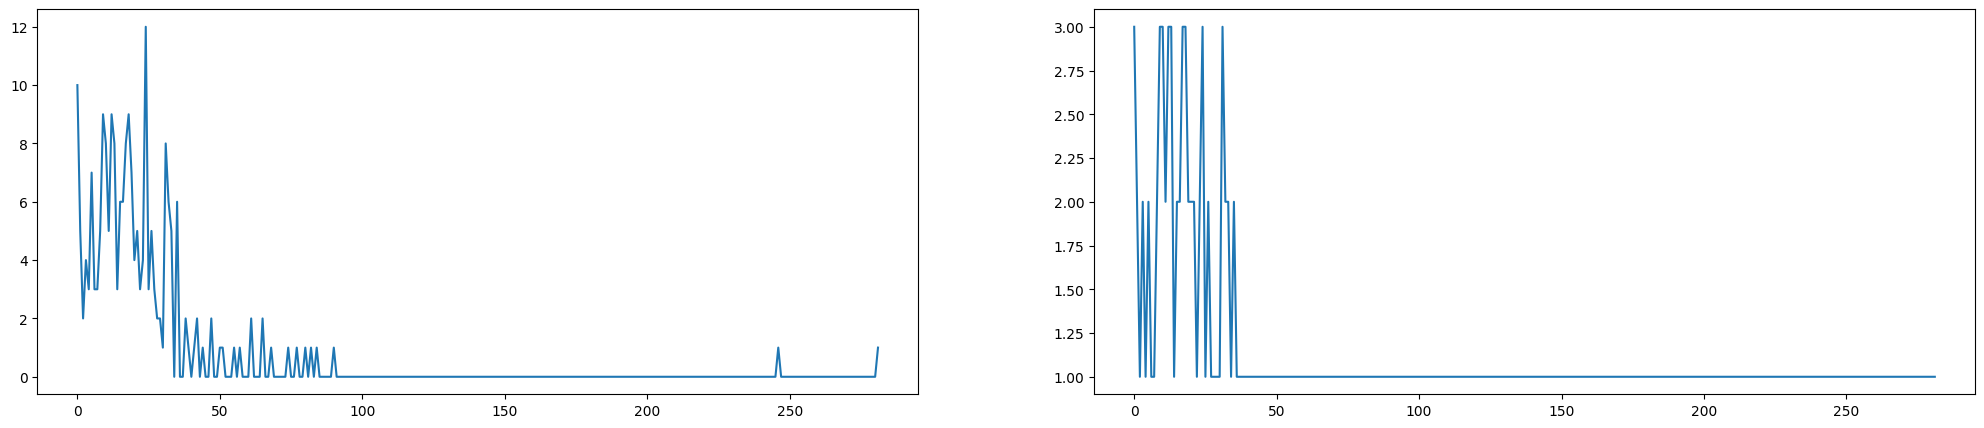

: 

In [91]:
temp = df_eda[df_eda["article_id"] == "0108775051"].reset_index()

plt.figure(figsize=(25,5))

plt.subplot(1,2,1)
plt.plot(temp["sales"])

plt.subplot(1,2,2)
plt.plot(temp["quantile"])